In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
from shapely.geometry import box
import rioxarray
from sklearn.cluster import DBSCAN

from src.utils import read_neon_trees

root = Path.cwd()

In [6]:
site_folder = '2019_BART_5' #'2019_HARV_6'
site = 'BART'
epsg = "EPSG:26919"

bart_trees = read_neon_trees(root,site,epsg=epsg)

bart_trees['crown_buffer'] = bart_trees.apply(lambda row: row['geometry'].buffer(row['ninetyCrownDiameter']/2) if not np.isnan(row['ninetyCrownDiameter']) else np.nan, axis=1)

In [4]:
b = xr.open_dataarray(root / 'sentinel_data' / '2019_bart_indices.nc')
b = b.rio.write_crs(26919).rio.set_spatial_dims(x_dim="x",y_dim="y",).rio.write_coordinate_system()

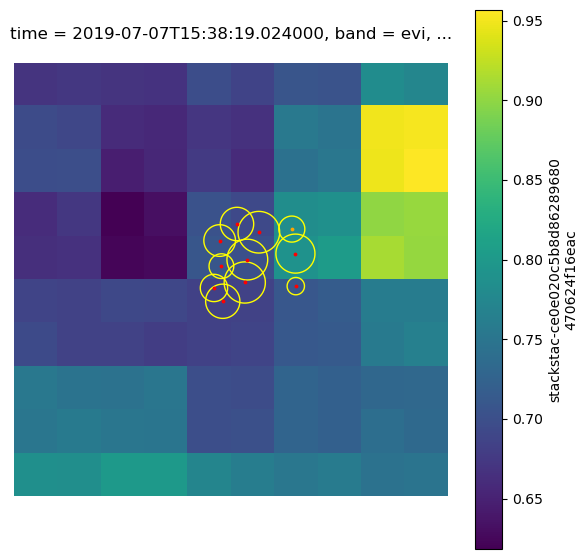

In [25]:
# buffer arbitrary cluster
buffer = bart_trees.iloc[1273:1274,].buffer(50)

points_idx = buffer.sindex.query(bart_trees.geometry, predicate="intersects")[0]
clipped_trees = bart_trees.iloc[points_idx]

# tt_idx = buffer.sindex.query(tt.geometry, predicate="intersects")[0]
# clipped_tt = tt.iloc[tt_idx]

clip_df = gpd.GeoDataFrame(
    geometry=[box(*buffer.total_bounds)],
    crs="EPSG:26919"
)

clipped_raster = b.isel(band=1,time=12).rio.clip(clip_df.geometry.values, crs=26919, drop=True, invert=False)
clipped_beech = clipped_trees.loc[clipped_trees['taxonID']=='FAGR']
clipped_nonbeech = clipped_trees.loc[clipped_trees['taxonID']!='FAGR']

fig, ax = plt.subplots(ncols=1, figsize=(7, 7))

clipped_raster.plot.imshow(ax=ax)

#clipped_beech.plot(ax=ax,color='orange',markersize=3)
#clipped_nonbeech.plot(ax=ax,color='red',markersize=3)
#clipped_trees['crown_buffer'].plot(ax=ax, edgecolor='pink',facecolor='none')



f2['crown_buffer'].plot(ax=ax, edgecolor='yellow',facecolor='none')

f2_beech = f2.loc[f2['taxonID']=='FAGR']
f2_nonbeech = f2.loc[f2['taxonID']!='FAGR']

f2_beech.plot(ax=ax,color='orange',markersize=3)
f2_nonbeech.plot(ax=ax,color='red',markersize=3)
#f['crown_buffer'].plot(ax=ax, edgecolor='black',facecolor='none')

ax.set_axis_off()

In [16]:
def filter_trees_scholl(gdf):
       
        filtered_trees = gdf.loc[gdf['crown_buffer'].area > 2]
        to_drop = set()
        
        
        for ix, row in filtered_trees.iterrows():
            #Get list of trees without current tree
            working_copy = filtered_trees.loc[filtered_trees.index != ix]
            #See if current tree is fully contained by any higher trees
            coverage = working_copy.crown_buffer.contains(row.crown_buffer)
            cover_gdf = working_copy.loc[coverage]
            if (cover_gdf['height']>row['height']).sum() > 0:
                to_drop.add(ix)
            #See if current tree intersects with any higher trees
            intersect = working_copy.crown_buffer.intersects(row.crown_buffer)
            inter_gdf = working_copy.loc[intersect]
            if (inter_gdf['height']>row['height']).sum() > 0:
                to_drop.add(ix)

        filtered_trees =  filtered_trees.drop(to_drop).reset_index(drop=True)
        
        return filtered_trees

In [13]:
f = filter_trees_scholl(clipped_trees)

In [19]:
chm_dif_med = bart_trees.chm_dif.median()
chm_dif_std = bart_trees.chm_dif.std()

In [20]:
def filter_trees(gdf,gdf_clip):
        #Filter for trees within 1.5 std of median difference between survey observed tree height and chm observed tree height
        chm_dif_med = gdf.chm_dif.median()
        chm_dif_std = gdf.chm_dif.std()
        threshold1 = chm_dif_med-chm_dif_std*1.5
        threshold2 = chm_dif_med + chm_dif_std*1.5

        filtered_trees = gdf_clip.loc[(gdf_clip.chm_dif > threshold1) & (gdf_clip.chm_dif < threshold2)].reset_index(drop=True)
        if len(filtered_trees) == 0:
            return filtered_trees
        #Calculate distance matrix between all trees
        dist_matrix = filtered_trees.geometry.apply(lambda g: filtered_trees.distance(g)).to_numpy()
        #Grab upper triangle of distance matrix since dist mat is symmetrical
        upper_tri = dist_matrix[np.triu_indices_from(dist_matrix, k=1)]
        #Find a distance threshold for trees that might be too close together
        thresh = np.median(upper_tri) - upper_tri.std()*1.5
        #Get index pairs where trees are suspiciously close
        #Sort + Set to remove redundant pairs i.e. (12, 14) and (14, 12) and identical pairs
        sus_indexes = set(tuple(sorted(x)) for x in np.argwhere(dist_matrix<thresh) if x[0] != x[1])
        to_drop = list()
        for sus in sus_indexes:

            height_0 = filtered_trees.loc[sus[0]]['height']
            height_1 = filtered_trees.loc[sus[1]]['height']
            #When two trees are very close, pick the higher one as observed from ground survey (not chm for consistency with scholl), drop the shorter one
            to_add = sus[0] if height_1>=height_0 else sus[1]
            to_drop.append(to_add)

        to_drop = set(to_drop)
        filtered_trees = filtered_trees.drop(to_drop).reset_index(drop=True)
        
        return filtered_trees

In [21]:
f2 = filter_trees(bart_trees,clipped_trees)